In [6]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Read in the data file and convert it into a pandas dataframe

In [7]:
def make_df(filepath, ncols = 10, csvname = None):
    """Reads in a the file and converts it into a pandas dataframe where we have ncols equally spaced bins for
    the ask and bid data"""
    df = pd.DataFrame()
    with open(filepath) as data_file:        
        count = 0
        cols = []
        for i in range(ncols):
            cols.append("bid" + str(i + 1))
        for i in range(ncols):
            cols.append("ask" + str(i + 1))
        for line in data_file:
            #The time is every even line, whereas the actual data is every odd line
            if count%2 == 1:
                try:
                    data = json.loads(line)
                except(ValueError, e):
                    return -1

                #Read in the data if there aren't any errors
                if len(data['error']) == 0:
                    #Make an array of length ncols with each "bin" having an equal number of bids
                    bids = data['result']['XXBTZUSD']['bids']
                    bid_sums = []
                    bid_sum = 0
                    for i in range(len(bids)): 
                        bid_sum += float (bids[i][1])
                        if ((i+1) % int(len(bids)/ncols)) == 0 and i != 0:
                            bid_sums.append(bid_sum)

                    #Make an array of length ncols with each "bin" having an equal number of bids
                    asks = data['result']['XXBTZUSD']['asks']
                    ask_sums = []
                    ask_sum = 0
                    for i in range(len(asks)): 
                        ask_sum += float (asks[i][1])
                        if ((i+1) % int(len(asks)/ncols)) == 0 and i != 0:
                            ask_sums.append(ask_sum)

                    #Normalize the data to values 0-1
                    bid_sums = [i/bid_sums[-1] for i in bid_sums]
                    ask_sums = [i/ask_sums[-1] for i in ask_sums]

                    #Append this time to the dataframe
                    if count == 1:
                        df = pd.DataFrame([bid_sums + ask_sums], columns= cols)
                    else:
                        df2 = pd.DataFrame([bid_sums + ask_sums], columns= cols)
                        df = df.append(df2)
            count += 1
        if(csvname != None):
            df.to_csv(csvname, index = False);
    return df


# Plot two features of the data against each other

In [8]:
def plot_data(feature1, feature2, df, model):
    """Plots the data and the clustered data side by side"""
    assert feature1 in df.columns, "The first feature you entered does not exist in the dataframe"
    assert feature2 in df.columns, "The second feature you entered does not exist in the dataframe"
    
    fig = plt.figure(figsize=(14,7))

    # Plot Original
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(df[feature1], df[feature2], s=40)
    ax.set_title('Actual')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

    labels = model.labels_

    # Plot Models
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(df[feature1], df[feature2], c=labels.astype(np.float), edgecolor='k', s=40)
    ax2.set_title('K Mean')
    ax2.set_xlabel(feature1)
    ax2.set_ylabel(feature2)
    
    plt.show(fig)

In [91]:
def plot_clusters(model):
    #Gets the centers of the different clusters
    clusters = model.cluster_centers_;
    #Create subplot for each cluster
    fig, axarr = plt.subplots(len(clusters));
    count = 0;
    for cluster in model.cluster_centers_:
        #Get and reverse first half of the cluster (bids)
        first_half = cluster[:int(len(cluster) / 2)]
        first_half = first_half[::-1]
        #Combine reversed first half with second half
        y_feature = list(first_half) + list(cluster[int(len(cluster) / 2):])
        #Plot the cluster center curve
        axarr[count].plot(y_feature)
        axarr[count].set_title("Cluster " + str(count))
        count += 1;
        
    plt.show(fig)

# The main section of the code to run

In [31]:
def run_file(filepath, feature1, feature2, clusters, ncols = 10):
    assert type(clusters) == int, "The number of clusters must be a positive integer"
    df = make_df(filepath, ncols = ncols)
    assert type(df) == pd.core.frame.DataFrame, "Please enter a valid file"
    model = KMeans(n_clusters=clusters)
    model.fit(df)
    plot_clusters(model);
    #plot_data(feature1, feature2, df, model) 

3


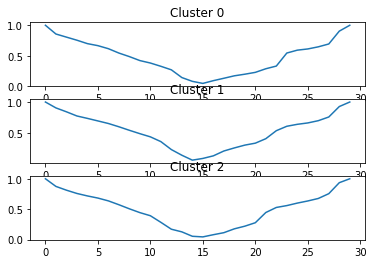

In [94]:
run_file("/Users/Kevin/Documents/Data Ventures/Data-Ventures-Workshop-4/orderbook_kraken_2017-10-10", 'bid5', 'ask5', 3, ncols = 15)